In [1]:
!pip install pyspark

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import pandas as pd
import pylab as pl
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
spark = SparkSession.builder.appName("Datacamp Pyspark Tutorial").config("spark.memory.offHeap.enabled","true").config("spark.memory.offHeap.size","10g").getOrCreate()

24/01/17 12:16:37 WARN Utils: Your hostname, guhan-Lenovo-ideapad-530S-15IKB resolves to a loopback address: 127.0.1.1; using 192.168.2.189 instead (on interface wlp2s0)
24/01/17 12:16:37 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/01/17 12:16:38 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
df = spark.read.csv('../dataset/datacamp_ecommerce.csv',header=True,escape="\"")

In [23]:
df.show(5,0)

+---------+---------+-----------------------------------+--------+------------+---------+----------+--------------+
|InvoiceNo|StockCode|Description                        |Quantity|InvoiceDate |UnitPrice|CustomerID|Country       |
+---------+---------+-----------------------------------+--------+------------+---------+----------+--------------+
|536365   |85123A   |WHITE HANGING HEART T-LIGHT HOLDER |6       |12/1/10 8:26|2.55     |17850     |United Kingdom|
|536365   |71053    |WHITE METAL LANTERN                |6       |12/1/10 8:26|3.39     |17850     |United Kingdom|
|536365   |84406B   |CREAM CUPID HEARTS COAT HANGER     |8       |12/1/10 8:26|2.75     |17850     |United Kingdom|
|536365   |84029G   |KNITTED UNION FLAG HOT WATER BOTTLE|6       |12/1/10 8:26|3.39     |17850     |United Kingdom|
|536365   |84029E   |RED WOOLLY HOTTIE WHITE HEART.     |6       |12/1/10 8:26|3.39     |17850     |United Kingdom|
+---------+---------+-----------------------------------+--------+------

In [24]:
df.count()

100

In [25]:
df.select('CustomerID').distinct().count()

7

In [27]:
df.groupBy('Country').agg(countDistinct('CustomerID').alias('country_count')).show()

+--------------+-------------+
|       Country|country_count|
+--------------+-------------+
|        France|            1|
|United Kingdom|            6|
+--------------+-------------+



In [28]:
df.groupBy('Country').agg(countDistinct('CustomerID').alias('country_count')).orderBy(desc('country_count')).show()

+--------------+-------------+
|       Country|country_count|
+--------------+-------------+
|United Kingdom|            6|
|        France|            1|
+--------------+-------------+



In [29]:
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")
df = df.withColumn('date',to_timestamp("InvoiceDate", 'yy/MM/dd HH:mm'))
df.select(max("date")).show()

+-------------------+
|          max(date)|
+-------------------+
|2012-01-10 09:37:00|
+-------------------+



In [30]:
df.select(min("date")).show()

+-------------------+
|          min(date)|
+-------------------+
|2012-01-10 08:26:00|
+-------------------+



In [31]:
df = df.withColumn("from_date", lit("12/1/10 08:26"))
df = df.withColumn('from_date',to_timestamp("from_date", 'yy/MM/dd HH:mm'))

df2=df.withColumn('from_date',to_timestamp(col('from_date'))).withColumn('recency',col("date").cast("long") - col('from_date').cast("long"))

In [32]:
df2 = df2.join(df2.groupBy('CustomerID').agg(max('recency').alias('recency')),on='recency',how='leftsemi')

In [33]:
df2.show(5,0)

+-------+---------+---------+-------------------------------+--------+------------+---------+----------+--------------+-------------------+-------------------+
|recency|InvoiceNo|StockCode|Description                    |Quantity|InvoiceDate |UnitPrice|CustomerID|Country       |date               |from_date          |
+-------+---------+---------+-------------------------------+--------+------------+---------+----------+--------------+-------------------+-------------------+
|540    |536369   |21756    |BATH BUILDING BLOCK WORD       |3       |12/1/10 8:35|5.95     |13047     |United Kingdom|2012-01-10 08:35:00|2012-01-10 08:26:00|
|1140   |536370   |22728    |ALARM CLOCK BAKELIKE PINK      |24      |12/1/10 8:45|3.75     |12583     |France        |2012-01-10 08:45:00|2012-01-10 08:26:00|
|1140   |536370   |22727    |ALARM CLOCK BAKELIKE RED       |24      |12/1/10 8:45|3.75     |12583     |France        |2012-01-10 08:45:00|2012-01-10 08:26:00|
|1140   |536370   |22726    |ALARM CLOCK

In [34]:
df2.printSchema()

root
 |-- recency: long (nullable = true)
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: string (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: string (nullable = true)
 |-- CustomerID: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- from_date: timestamp (nullable = true)



In [35]:
df_freq = df2.groupBy('CustomerID').agg(count('InvoiceDate').alias('frequency'))

In [36]:
df_freq.show(5,0)

+----------+---------+
|CustomerID|frequency|
+----------+---------+
|15100     |1        |
|15291     |2        |
|17850     |18       |
|13748     |1        |
|12583     |20       |
+----------+---------+
only showing top 5 rows



In [37]:
df3 = df2.join(df_freq,on='CustomerID',how='inner')

In [38]:
df3.printSchema()

root
 |-- CustomerID: string (nullable = true)
 |-- recency: long (nullable = true)
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: string (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- from_date: timestamp (nullable = true)
 |-- frequency: long (nullable = false)



In [39]:
m_val = df3.withColumn('TotalAmount',col("Quantity") * col("UnitPrice"))

In [40]:
m_val = m_val.groupBy('CustomerID').agg(sum('TotalAmount').alias('monetary_value'))

In [41]:
finaldf = m_val.join(df3,on='CustomerID',how='inner')

In [42]:
finaldf = finaldf.select(['recency','frequency','monetary_value','CustomerID']).distinct()

In [43]:
finaldf.show(5,0)

+-------+---------+------------------+----------+
|recency|frequency|monetary_value    |CustomerID|
+-------+---------+------------------+----------+
|2580   |1        |350.4             |15100     |
|3960   |2        |328.8             |15291     |
|4080   |18       |282.06000000000006|17850     |
|3960   |18       |282.06000000000006|17850     |
|2040   |1        |204.0             |13748     |
+-------+---------+------------------+----------+
only showing top 5 rows



In [47]:
assemble=VectorAssembler(inputCols=[
    'recency','frequency','monetary_value'
], outputCol='features')

assembled_data=assemble.transform(finaldf)

scale=StandardScaler(inputCol='features',outputCol='standardized')
data_scale=scale.fit(assembled_data)
data_scale_output=data_scale.transform(assembled_data)

In [48]:
data_scale_output.select('standardized').show(2,truncate=False)

+-----------------------------------------------------------+
|standardized                                               |
+-----------------------------------------------------------+
|[1.7655857019430088,0.11303378701351413,1.4727975400140534]|
|[2.709968751819502,0.22606757402702826,1.3820086505611324] |
+-----------------------------------------------------------+
only showing top 2 rows



In [50]:
cost = np.zeros(10)

evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized',metricName='silhouette', distanceMeasure='squaredEuclidean')

for i in range(2,10):
    KMeans_algo=KMeans(featuresCol='standardized', k=i)
    KMeans_fit=KMeans_algo.fit(data_scale_output)
    output=KMeans_fit.transform(data_scale_output)
    cost[i] = KMeans_fit.summary.trainingCost

24/01/11 16:17:31 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/01/11 16:17:31 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


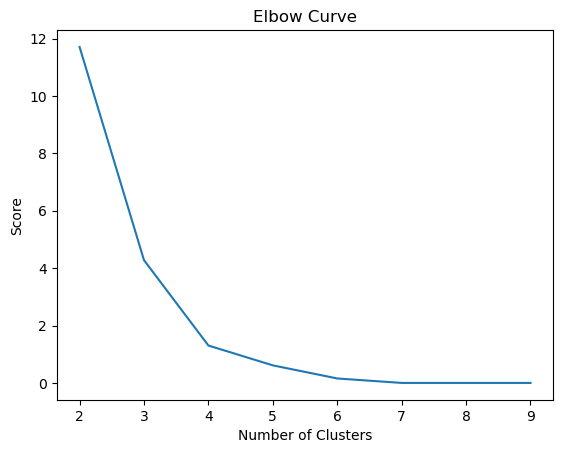

In [51]:
df_cost = pd.DataFrame(cost[2:])
df_cost.columns = ["cost"]
new_col = range(2,10)
df_cost.insert(0, 'cluster', new_col)
pl.plot(df_cost.cluster, df_cost.cost)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

In [52]:
KMeans_algo=KMeans(featuresCol='standardized', k=3)
KMeans_fit=KMeans_algo.fit(data_scale_output)

In [53]:
preds=KMeans_fit.transform(data_scale_output)

preds.show(5,0)

+-------+---------+------------------+----------+--------------------------------+-----------------------------------------------------------+----------+
|recency|frequency|monetary_value    |CustomerID|features                        |standardized                                               |prediction|
+-------+---------+------------------+----------+--------------------------------+-----------------------------------------------------------+----------+
|2580   |1        |350.4             |15100     |[2580.0,1.0,350.4]              |[1.7655857019430088,0.11303378701351413,1.4727975400140534]|0         |
|3960   |2        |328.8             |15291     |[3960.0,2.0,328.8]              |[2.709968751819502,0.22606757402702826,1.3820086505611324] |1         |
|4080   |18       |282.06000000000006|17850     |[4080.0,18.0,282.06000000000006]|[2.7920890170261536,2.0346081662432542,1.1855515814393949] |1         |
|3960   |18       |282.06000000000006|17850     |[3960.0,18.0,282.0600000000

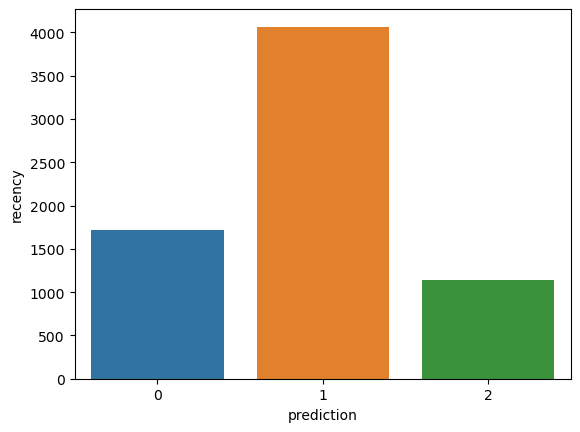

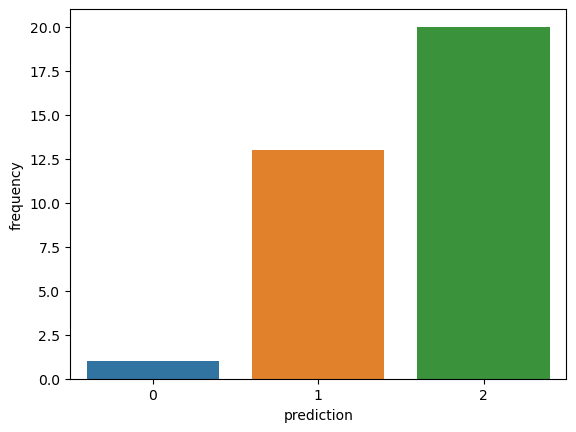

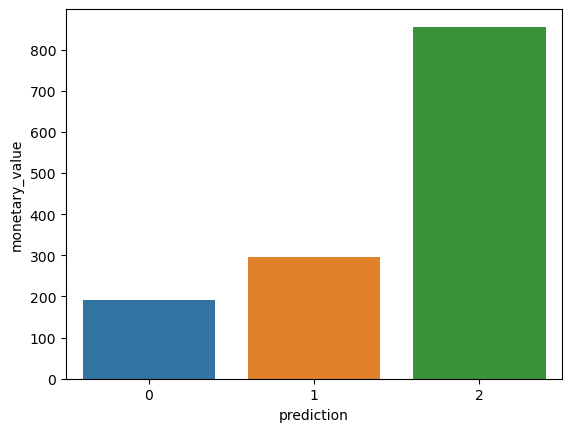

In [54]:
df_viz = preds.select('recency','frequency','monetary_value','prediction')
df_viz = df_viz.toPandas()
avg_df = df_viz.groupby(['prediction'], as_index=False).mean()

list1 = ['recency','frequency','monetary_value']

for i in list1:
    sns.barplot(x='prediction',y=str(i),data=avg_df)
    plt.show()

In [5]:
spark.stop()